In [1]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

2022-09-16 00:29:14.249744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-16 00:29:14.336043: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nikhil/.mujoco/mujoco210/bin
2022-09-16 00:29:14.336059: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-16 00:29:14.354053: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-16 00:

In [3]:
# Set up a virtual display to render the Lunar Lander environment.
Display(visible=False, size=(840, 480)).start()

# Set the random seed for TensorFlow
tf.random.set_seed(1234)

In [4]:
MEMORY_SIZE = 100_000  # size of memory buffer
GAMMA = 0.995  # discount factor
ALPHA = 1e-3  # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

In [9]:
!pip install swig gym[box2d]

     |████████████████████████████████| 374 kB 2.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2349123 sha256=8674bd562a8bb38cc07c3eebd059ab9e8f50482fb6c307b2d49945c1687e69a9
  Stored in directory: /home/nikhil/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
You should consider upgrading via the '/home/nikhil/PycharmProjects/RL_Algorithms_Survey/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
env = gym.make('LunarLander-v2')

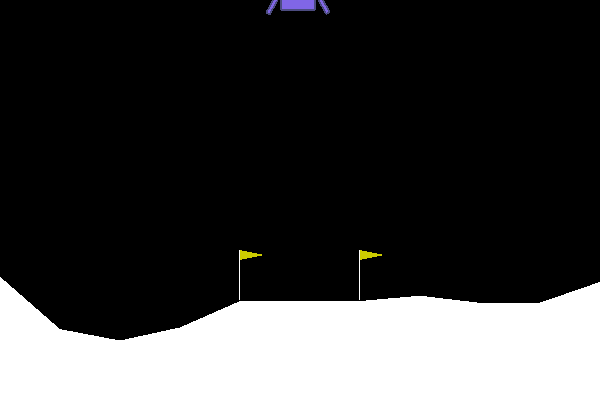

In [5]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [6]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [7]:
# Reset the environment and get the initial state.
initial_state = env.reset()

In [8]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state)
    print("Action:", action)
    print("Next State:", next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", done)
    print("Info:", info)

Initial State: [-0.006 1.417 -0.572 0.265 0.007 0.130 0.000 0.000]
Action: 0
Next State: [-0.011 1.422 -0.571 0.240 0.013 0.128 0.000 0.000]
Reward Received: -0.07364834578297064
Episode Terminated: False
Info: {}


In [9]:
# UNQ_C1
# GRADED CELL

# Create the Q-Network
q_network = Sequential([
    ### START CODE HERE ### 
    tf.keras.layers.InputLayer(input_shape=state_size),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_actions, activation='linear'),
    ### END CODE HERE ### 
])

# Create the target Q^-Network
target_q_network = Sequential([
    ### START CODE HERE ### 
    tf.keras.layers.InputLayer(input_shape=state_size),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_actions, activation='linear'),
    ### END CODE HERE ###
])

### START CODE HERE ### 
optimizer = Adam(learning_rate=ALPHA)
### END CODE HERE ###

2022-09-16 00:29:47.873644: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nikhil/.mujoco/mujoco210/bin
2022-09-16 00:29:47.873685: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-16 00:29:47.873714: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nikhil-pc): /proc/driver/nvidia/version does not exist
2022-09-16 00:29:47.873939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [11]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + gamma * max_qsa * (1 - done_vals)
    ### END CODE HERE ###

    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(q_values, y_targets)
    ### END CODE HERE ### 

    return loss

In [12]:
@tf.function
def agent_learn(experiences, gamma):
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

In [20]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100  # number of total points to use for averaging
epsilon = 1.0  # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Number of hovering episodes
hover_count = 0

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        # If t = max_num_timesteps - 1, then that means it's in hovering state. Or something similar
        if t == max_num_timesteps - 1: hover_count += 1

        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)

        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)

        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))

        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)

            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i + 1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i + 1) % num_p_av == 0:
        print(f"\rEpisode {i + 1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i + 1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time / 60):.2f} min)")

print('\n Number of hovering episodes:', hover_count)

Episode 100 | Total point average of the last 100 episodes: -117.07
Episode 200 | Total point average of the last 100 episodes: -44.956
Episode 300 | Total point average of the last 100 episodes: 49.580
Episode 394 | Total point average of the last 100 episodes: 201.79

Environment solved in 394 episodes!

Total Runtime: 306.58 s (5.11 min)

 Number of hovering episodes: 84


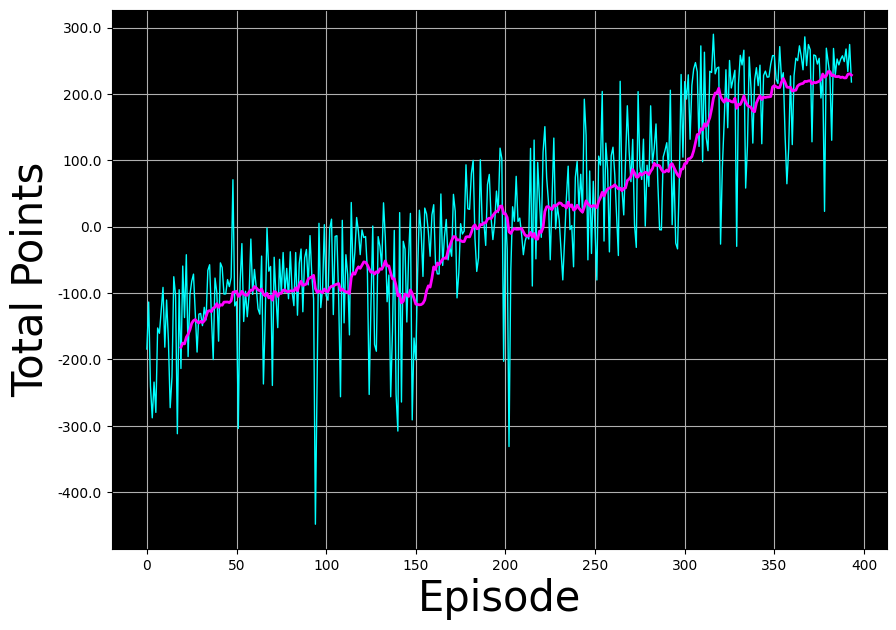

In [22]:
# Plot the point history
utils.plot_history(total_point_history)

In [15]:
# Suppress warnings from imageio
import logging

logging.getLogger().setLevel(logging.ERROR)

In [18]:
!pip install imageio-ffmpeg

     |████████████████████████████████| 26.9 MB 288 kB/s            
You should consider upgrading via the '/home/nikhil/PycharmProjects/RL_Algorithms_Survey/venv/bin/python -m pip install --upgrade pip' command.


In [19]:
filename = "./videos/lunar_lander.mp4"

utils.create_video(filename, env, q_network)
# utils.embed_mp4(filename)

[swscaler @ 0x6ece880] Warning: data is not aligned! This can lead to a speed loss
